# Practice 5. Monte Carlo Simulation 

### 1. 기대값  
연속형 확률변수 $X\sim N(\mu, \sigma^2)$가 $(a,b),~ -\infty<a<b<\infty$ 구간에 존재한다고 하자. 이 때 $X, a<X<b$를 truncated normal distribution을 가진다고 한다. $\mu=-8, \sigma=2, a=-10, b=10$인 경우 truncated normal distribution을 따르는 확률변수의 기대값을 Monte Carlo Simulation을 통해 구하시오. 

(참고) 연속형 확률변수의 기대값은 아래와 같이 정의된다. 
$$E(X) = \int x f(x) dx $$

https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
mu=-8
sigma = 2
x = stats.norm.rvs(mu, sigma,size = 100000)
a = -10
b = 10


In [2]:
# 내가 한 방법
x[(x>a)&(x<b)].mean() # MC을 통한 기대값

-7.425666090501797

In [3]:
np.mean([x_ for x_ in x if a < x_ < b]) # MC을 통한 기대값

-7.425666090501797

In [4]:
# 이론적인 기대값 - 위 사이트 들어가면 나와있다.
alpha = (a-mu)/sigma
beta = (b-mu)/sigma
Z= stats.norm.cdf(beta)- stats.norm.cdf(alpha)

In [6]:
mu + (stats.norm.pdf(alpha)-stats.norm.pdf(beta))/Z *sigma

-7.424800058121643

### 2.  Sales Comission 
한 회사에서는 판매원들에게 Sales commission을 제공함으로써 판매를 촉진하고 있다. 내년의 예산 계획을 위핸 Sales comission의 기대값을 구하고자 한다.  Sale comission rate은 판매 목표 달성률에 따라 아래와 같이 책정된다. 
<img src=https://pbpython.com/images/Excel_Table_4.png>

Sales commission이 계산되는 예는 아래와 같다.
<img src=https://pbpython.com/images/Excel_Table_5.png>
<img src=https://pbpython.com/images/Excel_Table_6.png>

지금까지의 기록을 보았을 때 판매 목표 달성률은 평균 1, 표준편차 0.1인 대칭 분포를 가지고 있었다. 따라서 해당 정규분포에서 각 판매원의 판매 목표 달성률을 발생시킨다. 

In [4]:
avg = 1
std_dev = .1
num_reps = 500 #500명의 판매원
#num_reps = 300
num_simulations = 1000 #1000번 반복
pct_to_target = stats.norm.rvs(avg, std_dev, size=num_reps)

기록을 통해 Sales target은 아래의 분포를 가지고 있음을 확인하였다. 따라서 아래의 확률분포를 가진 이산형 확률변수의 값을 Sales target으로 발생시킨다. 


| Sales Target| Proportion |
|---------|------|
| 75,000  | 0.3  |
| 100,000 | 0.3  |
| 200,000 | 0.2  |
| 300,000 | 0.1  |
| 400,000 | 0.05 |
| 500,000 | 0.05 |

In [5]:
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, size=num_reps, p=sales_target_prob)

In [6]:
df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                               'Sales_Target': sales_target})

In [7]:
df.head()

,Pct_To_Target,Sales_Target
0,0.927770,300000
1,1.012367,75000
2,0.975056,75000
3,0.987254,500000
4,1.059148,200000


In [8]:
df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

In [9]:
df.head()

,Pct_To_Target,Sales_Target,Sales
0,0.927770,300000,278330.921901
1,1.012367,75000,75927.510695
2,0.975056,75000,73129.210178
3,0.987254,500000,493627.220532
4,1.059148,200000,211829.517400


Commision rate의 계산을 위한 함수 

In [10]:
def calc_commission_rate(x):
    """ Return the commission rate based on the table:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

In [11]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

In [12]:
df.head()

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,0.927770,300000,278330.921901,0.03,8349.927657
1,1.012367,75000,75927.510695,0.04,3037.100428
2,0.975056,75000,73129.210178,0.03,2193.876305
3,0.987254,500000,493627.220532,0.03,14808.816616
4,1.059148,200000,211829.517400,0.04,8473.180696


Monte Carlo Simulation을 통해 총 commision amount를 계산하고 이 값의 분포와 평균을 관찰한다. 

In [17]:
# Define a list to keep all the results from each simulation that we want to analyze
all_stats = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose random inputs for the sales targets and percent to target
    sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Back into the sales number using the percent to target rate
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Determine the commissions rate and calculate it
    df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # We want to track sales,commission amounts and sales targets over all the simulations
    all_stats.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

In [18]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Sales',
                                                           'Commission_Amount',
                                                           'Sales_Target'])

In [19]:
results_df.head()

,Sales,Commission_Amount,Sales_Target
0,81029500.0,2743030.0,81475000
1,81329750.0,2743690.0,81800000
2,81698500.0,2780842.0,81750000
3,85226000.0,2899822.0,85375000
4,82620000.0,2786552.0,83100000


#### Commission amount의 분포를 히스토그램으로 그리시오. 

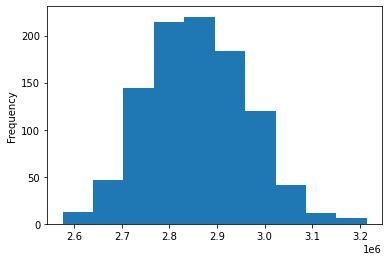

In [20]:
results_df.Commission_Amount.plot.hist()
plt.show()

#### Commission amount의 기대값은 무엇인가? 내년 예산 반영을 위해 보수적으로 75 pecentile을 사용한다면 얼마를 예산으로 잡아야 하는가?

In [23]:
results_df.describe().style.format('{:,.0f}')
# 75% 값인 2,929,252만큼을 예산으로 한다.

,Sales,Commission_Amount,Sales_Target
count,"1,000","1,000","1,000"
mean,"83,695,108","2,858,230","83,687,525"
std,"2,758,697","104,770","2,713,554"
min,"75,950,750","2,575,628","75,725,000"
25%,"81,812,938","2,784,382","81,850,000"
50%,"83,600,250","2,853,442","83,650,000"
75%,"85,488,750","2,929,252","85,475,000"
max,"92,625,000","3,214,385","92,025,000"


In [ ]:
# mean = 2,858,737

#### 만일 Top commission rate 을 5%로 올린다면 commission amount의 기대값은 어떻게 변하는가? 

In [24]:
results_df.describe().style.format('{:,.0f}')

,Sales,Commission_Amount,Sales_Target
count,"1,000","1,000","1,000"
mean,"83,695,108","2,858,230","83,687,525"
std,"2,758,697","104,770","2,713,554"
min,"75,950,750","2,575,628","75,725,000"
25%,"81,812,938","2,784,382","81,850,000"
50%,"83,600,250","2,853,442","83,650,000"
75%,"85,488,750","2,929,252","85,475,000"
max,"92,625,000","3,214,385","92,025,000"


In [ ]:
# mean = 3,316,139

#### 만일 판매원의 수가 300명으로 줄어든다면 commission amount의 기대값은 어떻게 변하는가? 

In [53]:
results_df.describe().style.format('{:,.0f}')

,Sales,Commission_Amount,Sales_Target
count,"1,000","1,000","1,000"
mean,"50,231,038","1,714,647","50,239,850"
std,"2,066,812","78,094","2,043,904"
min,"43,939,500","1,490,648","43,650,000"
25%,"48,819,562","1,659,304","48,868,750"
50%,"50,188,375","1,715,956","50,300,000"
75%,"51,629,812","1,764,418","51,656,250"
max,"57,839,500","2,023,060","57,375,000"


In [ ]:
# mean = 1,714,647

### 3. Rejection Sampling 

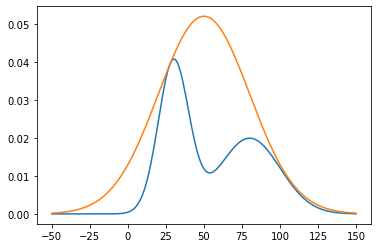

In [46]:
def p(x):
    return stats.norm.pdf(x, loc=30, scale=10) + stats.norm.pdf(x, loc=80, scale=20)


def q(x):
    return stats.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
M = max(p(x) / q(x)) # q(x) 안에 모두 포함되는 p(x)를 정의하기 위해 만들었다.

plt.plot(x, p(x))
plt.plot(x, M*q(x))
plt.show()

In [30]:
iter=10000
samples = []

for i in range(iter):
    y = np.random.normal(50, 30)
    u = np.random.uniform(0,1)
    
    if u <= p(y)/(M*q(y)):
        samples.append(y)

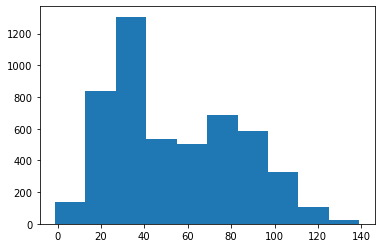

In [31]:
plt.hist(samples)
plt.show()
# 뽑히는 갯수가 뽑힐 가능성이 높은 애들이 확실히 많이 뽑혔다.

##### Reference
https://pbpython.com/monte-carlo.html